<a href="https://colab.research.google.com/github/tarunlc/Customer-Segmentation-Analysis/blob/main/CSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install pandas numpy matplotlib scikit-learn

Loading and cleaning data...
Successfully loaded data from Excel file.
Calculating RFM metrics...
Preparing data for clustering...
Determining optimal number of clusters...


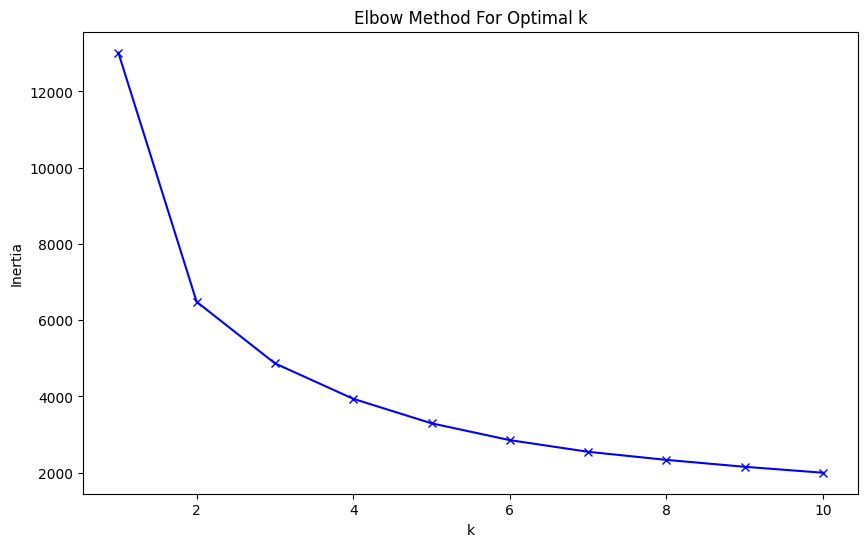

Performing K-Means clustering...

Cluster Summary:
        Recency          Frequency          Monetary                     \
           mean min  max      mean min  max     mean     min        max   
Cluster                                                                   
0         12.16   1  372     13.74   2  210  8093.36  808.62  280206.02   
1        181.44  23  374      1.32   1    6   343.22    3.75    2169.39   
2         17.72   1   51      2.18   1    7   560.13   35.40    3861.00   
3         71.40   8  366      4.08   1   14  1807.00  322.41   77183.60   

        CustomerID  
             count  
Cluster             
0              714  
1             1624  
2              833  
3             1167  


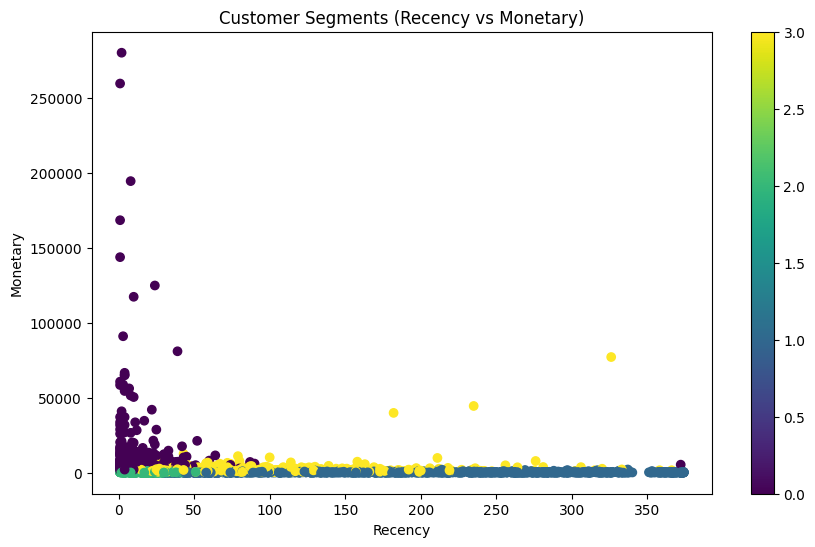


Results saved to 'customer_segments.csv'


In [6]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 1. Data Loading and Cleaning
def load_and_clean_data(file_path='Online Retail.xlsx'):
    try:
        # Load Excel file
        data = pd.read_excel(file_path, sheet_name=0)  # Modify sheet_name if necessary
        print("Successfully loaded data from Excel file.")

        # Convert InvoiceDate to datetime
        data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

        # Remove cancelled transactions (negative quantities or InvoiceNo starting with 'C')
        data = data[~data['InvoiceNo'].astype(str).str.startswith('C')]
        data = data[data['Quantity'] > 0]

        # Remove rows with missing CustomerID
        data = data.dropna(subset=['CustomerID'])

        # Calculate TotalPrice
        data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

        return data

    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None

# 2. RFM Analysis
def calculate_rfm(data):
    if data is None:
        return None

    # Set reference date (using max date + 1 day)
    reference_date = data['InvoiceDate'].max() + pd.Timedelta(days=1)

    # Group by CustomerID
    rfm = data.groupby('CustomerID').agg({
        'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
        'InvoiceNo': 'nunique',  # Frequency
        'TotalPrice': 'sum'  # Monetary
    }).reset_index()

    # Rename columns
    rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

    # Remove any negative values
    rfm = rfm[rfm['Monetary'] > 0]

    return rfm

# 3. Data Preparation for Clustering
def prepare_data_for_clustering(rfm):
    if rfm is None:
        return None, None

    # Log transform to handle skewed data
    rfm_transformed = rfm.copy()
    rfm_transformed['Recency'] = np.log1p(rfm_transformed['Recency'])
    rfm_transformed['Frequency'] = np.log1p(rfm_transformed['Frequency'])
    rfm_transformed['Monetary'] = np.log1p(rfm_transformed['Monetary'])

    # Standardize the features
    scaler = StandardScaler()
    rfm_scaled = scaler.fit_transform(rfm_transformed[['Recency', 'Frequency', 'Monetary']])

    return rfm_scaled, rfm_transformed

# 4. K-Means Clustering
def perform_kmeans_clustering(rfm_scaled, n_clusters=4):
    if rfm_scaled is None:
        return None, None

    # Apply K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(rfm_scaled)

    return clusters, kmeans

# 5. Elbow Method to determine optimal number of clusters
def plot_elbow_method(rfm_scaled):
    if rfm_scaled is None:
        return

    inertias = []
    k_range = range(1, 11)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(rfm_scaled)
        inertias.append(kmeans.inertia_)

    plt.figure(figsize=(10, 6))
    plt.plot(k_range, inertias, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Inertia')
    plt.title('Elbow Method For Optimal k')
    plt.show()

# 6. Main Execution
def main():
    # Load and clean data
    print("Loading and cleaning data...")
    data = load_and_clean_data('Online Retail.xlsx')  # Update this path if needed

    if data is None:
        return

    # Calculate RFM
    print("Calculating RFM metrics...")
    rfm = calculate_rfm(data)

    if rfm is None:
        return

    # Prepare data for clustering
    print("Preparing data for clustering...")
    rfm_scaled, rfm_transformed = prepare_data_for_clustering(rfm)

    if rfm_scaled is None:
        return

    # Plot elbow method to determine optimal clusters
    print("Determining optimal number of clusters...")
    plot_elbow_method(rfm_scaled)

    # Perform K-Means clustering
    print("Performing K-Means clustering...")
    clusters, kmeans = perform_kmeans_clustering(rfm_scaled, n_clusters=4)

    if clusters is None:
        return

    # Add cluster labels to RFM dataframe
    rfm['Cluster'] = clusters

    # Analyze cluster characteristics
    cluster_summary = rfm.groupby('Cluster').agg({
        'Recency': ['mean', 'min', 'max'],
        'Frequency': ['mean', 'min', 'max'],
        'Monetary': ['mean', 'min', 'max'],
        'CustomerID': 'count'
    }).round(2)

    print("\nCluster Summary:")
    print(cluster_summary)

    # Visualize clusters
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(rfm['Recency'], rfm['Monetary'], c=rfm['Cluster'], cmap='viridis')
    plt.xlabel('Recency')
    plt.ylabel('Monetary')
    plt.title('Customer Segments (Recency vs Monetary)')
    plt.colorbar(scatter)
    plt.show()

    # Save results
    rfm.to_csv('customer_segments.csv', index=False)
    print("\nResults saved to 'customer_segments.csv'")

if __name__ == "__main__":
    main()
